# Comparison of the HAFRO CTD data with ROMS model output

This notebook loads the observed CTD data and model data. It converts observed data to xarray format, and regrids model data onto lat,lon,z coordinates. There are some options available to reduce the model data loaded in for the sake of available memory. It then makes various plots of stratification and seasonal evolution of salinity and temperature. We use the roms-tools regridder.

In [44]:
# Loading in modules

import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy

import xarray as xr
from datetime import datetime, timedelta 
import dask
from scipy.interpolate import griddata
#from ocean_c_lab_tools import *
#from celluloid import Camera 
#import PyCO2SYS as csys
#import seawater as sw
from roms_regrid import *

### Setting parameters and paths

Here, all the parameters for model regridding, the paths for data storage, and the chosen length of model comparison are set, so that the remainder of the notebook needs minimal adjustment

In [45]:
HAFRO_path='/home/x-uheede/R/HAFRO/Hafro_cruises.xls'
model_grid_path="/home/x-uheede/S/Iceland2_MARBL_2024_60m/P_INPUT/Iceland2_grid_MAT1.nc"
# Grid parameters, only modify these if grid is made in MATLAB
vert_levels=60
theta_s_model=5
theta_b_model=2
hc_model=300
model_data_path="/home/x-uheede/S/Iceland2_NOMARBL_2024_NewV/Iceland2_MARBL_2024_his.20240[4-8]????????.nc"
months_analysis=[4,5,6,7,8] # enter the months you want to analyze for the model
# enter the dates you want to analyze for the observations
months_string_begin='01-04-2024'
months_string_end='31-08-2024'
target_depth_levels=[1,2,3,4,5,7,9,10,12,14,15,16,18,20,26,30,36,40,50,80] # Specify depth levels of interest
thinner=24*7 # specify the temporal frequency of data being read (i.e. no need to read in hourly data)


In [46]:
# Read in observed data
xls = pd.ExcelFile(HAFRO_path)

combo = pd.read_excel(xls, 'combo',decimal='.')

obs=xr.Dataset.from_dataframe(combo)

# reformat into xarray dataset, HV is our station number indicator
obs=obs.set_index(index=['HV','Depth','mon/day/yr'])
obs=obs.drop_duplicates('index')
obs=obs.unstack('index')
# renaming variables that have strange formatting in the excelsheet
obs=obs.rename(name_dict={'mon/day/yr':'time','Depth':'depth','Latitude(¬∞N)':'lat','Longitude(¬∞E)':'lon'})


In [47]:
# define location which calculations the average location of each station
def get_location(obs, hv_values):
    locations = []
    for hv in hv_values:
        lat = obs['lat'].sel(HV=hv).isel(depth=0).mean('time').squeeze().values
        lon = obs['lon'].sel(HV=hv).isel(depth=0).mean('time').squeeze().values + 360
        locations.append([lat, lon])
    return locations

# List of HV values
hv_values = range(1, 13)

# Get the locations
locations = get_location(obs, hv_values)

In [48]:
from roms_tools import Grid, ROMSOutput

In [49]:
grid = Grid.from_file(
    model_grid_path
)

2025-12-08 13:09:31 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-12-08 13:09:31 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-12-08 13:09:31 - INFO - Total time: 0.003 seconds
2025-12-08 13:09:31 - INFO - ========================================================================================================


In [50]:
#Only run this cell if grid is made in MATLAB
grid.update_vertical_coordinate(N=vert_levels, theta_s=theta_s_model, theta_b=theta_b_model, hc=hc_model, verbose=False)

In [51]:
import xarray as xr
import numpy as np

# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds = roms_output.regrid(var_names=["temp", "salt"],depth_levels=target_depth_levels)

# Extract month for each time entry
months = ds.time.dt.month

# Dimensions we want
month_vals = months_analysis
types = ["mean", "std"]

# Create empty datasets for salt & temp
salt_data = []
temp_data = []

for m in month_vals:
    ds_m = ds.sel(time=months == m)

    # Calculate and append mean & std
    salt_mean = ds_m["salt"].thin({'time': thinner}).mean("time").load()
    salt_std  = ds_m["salt"].thin({'time': thinner}).std("time").load()
    temp_mean = ds_m["temp"].thin({'time': thinner}).mean("time").load()
    temp_std  = ds_m["temp"].thin({'time': thinner}).std("time").load()

    salt_data.append(xr.concat([salt_mean, salt_std], dim="type"))
    temp_data.append(xr.concat([temp_mean, temp_std], dim="type"))

# Concatenate over month dimension
salt_all = xr.concat(salt_data, dim="month")
temp_all = xr.concat(temp_data, dim="month")

# Assign coordinates
salt_all = salt_all.assign_coords(type=types, month=month_vals)
temp_all = temp_all.assign_coords(type=types, month=month_vals)

# Build final dataset
ds_monthly = xr.Dataset(
    {
        "salt": salt_all,
        "temp": temp_all,
    }
)

print(ds_monthly)



<xarray.Dataset> Size: 555MB
Dimensions:  (lat: 481, lon: 721, depth: 20, type: 2, month: 5)
Coordinates:
  * lat      (lat) float32 2kB 63.0 63.0 63.01 63.01 ... 64.99 64.99 65.0 65.0
  * lon      (lon) float32 3kB 336.0 336.0 336.0 336.0 ... 339.0 339.0 339.0
  * depth    (depth) float32 80B 1.0 2.0 3.0 4.0 5.0 ... 36.0 40.0 50.0 80.0
  * type     (type) <U4 32B 'mean' 'std'
  * month    (month) int64 40B 4 5 6 7 8
Data variables:
    salt     (month, type, lat, lon, depth) float32 277MB nan nan ... nan nan
    temp     (month, type, lat, lon, depth) float32 277MB nan nan ... nan nan


In [52]:
[months_analysis]

[[4, 5, 6, 7, 8]]

In [53]:
t=ds_monthly['temp']
s=ds_monthly['salt']

In [54]:
# Assuming locations is a list of lat/lon pairs
t_values = []
s_values = []
# Loop over the first 10 locations and store each selection in t_values
for i in range(12):
    lat, lon = locations[i]
    
    # Select the 't' values at the nearest lat/lon
    t_selected = t.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    s_selected = s.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    
    # Store the result in the listx
    t_values.append(t_selected)
    s_values.append(s_selected)

# Combine the selections into an xarray Dataset or DataArray
t_values_combined = xr.concat(t_values, dim='location')
s_values_combined = xr.concat(s_values, dim='location')

# Assign a location coordinate for clarity (optional)
t_values_combined = t_values_combined.assign_coords(location=('location', range(1, 13)))
s_values_combined = s_values_combined.assign_coords(location=('location', range(1, 13)))
t_values_combined['depth']=t_values_combined.depth*(-1)
s_values_combined['depth']=s_values_combined.depth*(-1)
# Now you have t_values as an xarray object (Dataset or DataArray)
#print(t_values_combined)


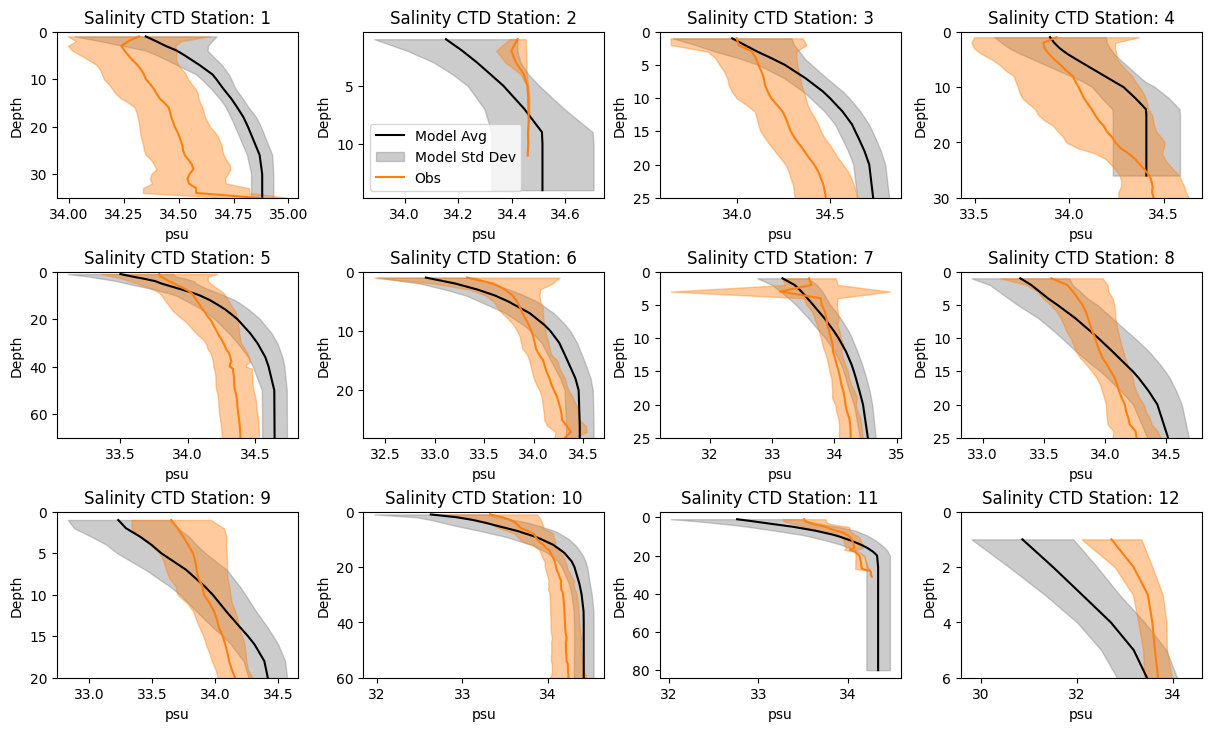

In [55]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(12, 6*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Loop through 12 locations
for i in range(12):
    loc = i + 1  # location index starts at 1

    # Extract model data
    model_mean = s_values_combined.isel(type=0).mean('month').sel(location=loc)
    model_std = s_values_combined.isel(type=1).mean('month').sel(location=loc)

    # Plot model average
    ax[i].plot(model_mean, s_values_combined.depth*(-1), label='Model Avg', color='black')

    # Plot shaded region for model standard deviation
    ax[i].fill_betweenx(s_values_combined.depth*(-1), model_mean - model_std, model_mean + model_std, 
                         color='grey', alpha=0.4, label='Model Std Dev')

    # Extract observed data
    ax[i].plot(obs['Salinity'].sel(HV=loc).dropna(dim='depth', how='all').sel(time=slice(months_string_begin, months_string_end)).mean('time'),
            obs.sel(HV=loc).dropna(dim='depth', how='all').depth, label='Obs', color=palette(2))

    obs_std = obs['Salinity'].sel(HV=loc).dropna(dim='depth', how='all').sel(time=slice(months_string_begin, months_string_end)).std('time')


    # Plot shaded region for observed standard deviation
    ax[i].fill_betweenx(obs.depth, (obs['Salinity'].sel(HV=loc).sel(time=slice(months_string_begin, months_string_end)).mean('time')-obs['Salinity'].sel(HV=loc).sel(time=slice(months_string_begin, months_string_end)).std('time')),(obs['Salinity'].sel(HV=loc).sel(time=slice(months_string_begin, months_string_end)).mean('time')+obs['Salinity'].sel(HV=loc).sel(time=slice(months_string_begin, months_string_end)).std('time')), color=palette(2), alpha=0.4)

    # Set depth limits for specific subplots
    ax[0].set_ylim(0,35)
    ax[2].set_ylim(0,25)
    ax[3].set_ylim(0,30)
    ax[4].set_ylim(0,70)
    ax[5].set_ylim(0,28)
    ax[6].set_ylim(0,25)
    ax[7].set_ylim(0,25)
    ax[8].set_ylim(0,20)
    ax[9].set_ylim(0,60)
    ax[11].set_ylim(0,6)

    # Set title, labels
    ax[i].set_title(f'Salinity CTD Station: {obs.HV[loc - 1].values}')
    ax[i].set_xlabel('psu')
    ax[i].set_ylabel('Depth')

    # Show legend only for the first subplot
    if i == 1:
        ax[i].legend()

for i in range(12):
    ax[i].invert_yaxis()
    
# Display the plot
plt.show()


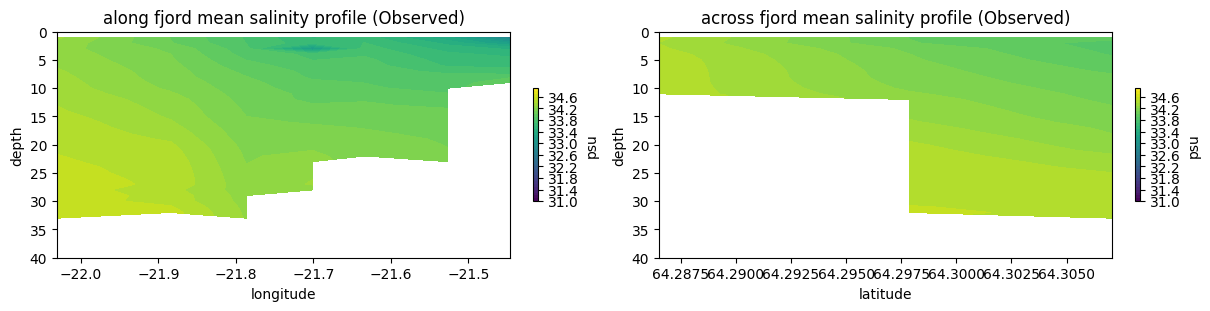

In [56]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(2.5,10,0.2)
data_psu1=obs['Salinity'].sel(time=slice(months_string_begin, months_string_end)).sel(HV=[1,3,5,7,9,10,12]).mean('time')
data_psu2=obs['Salinity'].sel(time=slice(months_string_begin, months_string_end)).sel(HV=[2,3,4]).mean('time')
data_t=obs['Temperature'].sel(time=slice(months_string_begin, months_string_end)).sel(HV=[1,3,5,7,9,10,12]).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_psu1.depth, data_psu1.transpose(),levels_psu)

#ax[1].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data.depth, data_t.transpose(),levels_t)
#ax[1].invert_yaxis()
c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_psu2.depth, data_psu2.transpose(),levels_psu)

ax[0].set_title('along fjord mean salinity profile (Observed)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean salinity profile (Observed)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

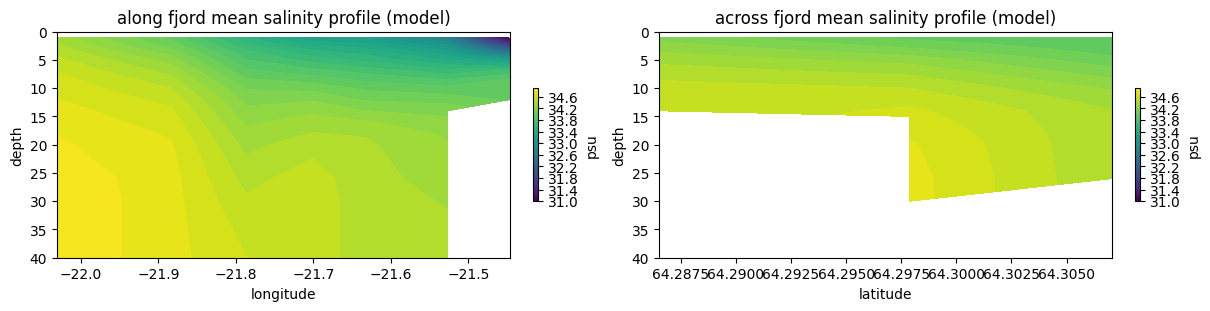

In [57]:
loc = np.array(locations)
levels_psu=np.arange(31,35,0.1)
levels_t=np.arange(2.5,10,0.2)
data_psu1=s_values_combined.isel(type=0).mean('month').sel(location=[1,3,5,7,9,10,12])
data_psu2=s_values_combined.isel(type=0).mean('month').sel(location=[2,3,4])


#data_t=obs['Temperature'].sel(HV=[1,3,5,7,9,10,12]).mean('time')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 3), constrained_layout=True)
ax = axarr.flatten()
c0=ax[0].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data_psu1.depth*(-1), data_psu1.transpose(),levels_psu)

#ax[1].contourf(loc[[1-1,3-1,5-1,7-1,9-1,10-1,12-1],1]-360,data.depth, data_t.transpose(),levels_t)
#ax[1].invert_yaxis()
c1=ax[1].contourf(loc[[2-1,3-1,4-1],0],data_psu2.depth*(-1), data_psu2.transpose(),levels_psu)

ax[0].set_title('along fjord mean salinity profile (model)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('depth')
ax[0].set_ylim(0,40)
plt.colorbar(c0,ax=ax[0], orientation='vertical', label='psu',shrink=0.5)
ax[0].invert_yaxis()

ax[1].set_title('across fjord mean salinity profile (model)')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('depth')
ax[1].set_ylim(0,40)
plt.colorbar(c1, ax=ax[1], orientation='vertical', label='psu',shrink=0.5)
ax[1].invert_yaxis()

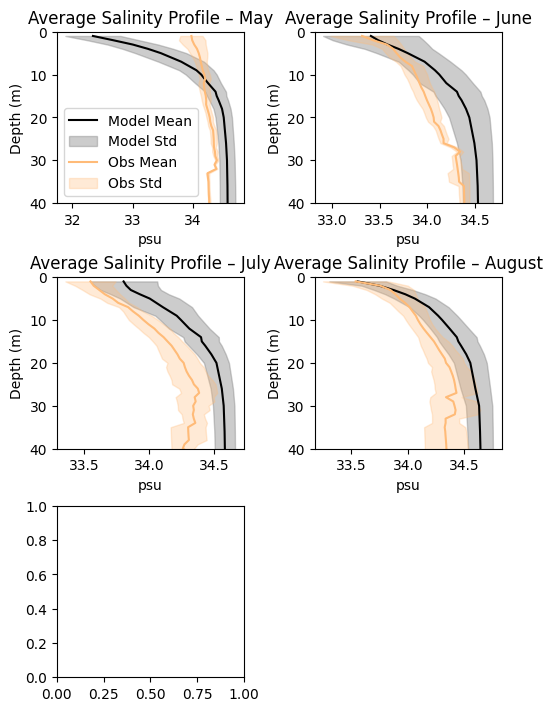

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIG ---
month_names = ["May", "June", "July", "August", "September"]
n_months = 4   # May–Sep
palette = plt.get_cmap("tab20")

# --- TAKE MEAN OVER ALL 12 STATIONS ---
model_mean = s_values_combined.isel(type=0).mean(dim="location")
model_std  = s_values_combined.isel(type=1).mean(dim="location")

# --- OBSERVATIONS: MEAN + STD ACROSS STATIONS ---
obs_monthly_mean = []
obs_monthly_std = []

for m in range(n_months):
    month_str = f"2024-{m+5:02d}"   # 05–09
    obs_sel = obs["Salinity"].sel(
        time=slice('2024-0'+str(m+4)+'-01','2024-0'+str(m+4)+'-30')
    )

    # mean over stations, then mean over time
    obs_mean_m = obs_sel.mean(dim="time").mean(dim="HV")
    obs_std_m  = obs_sel.std(dim="time").mean(dim="HV")

    obs_monthly_mean.append(obs_mean_m)
    obs_monthly_std.append(obs_std_m)

# --- SET UP FIGURE ---
fig, axarr = plt.subplots(
    nrows=3, ncols=2, figsize=(5, 7), constrained_layout=True
)
ax = axarr.flatten()

for m in range(n_months):

    # MODEL DATA FOR MONTH m
    model_mean_m = model_mean.isel(month=m+1)
    model_std_m  = model_std.isel(month=m+1)

    # OBS DATA FOR MONTH m
    obs_mean_m = obs_monthly_mean[m]
    obs_std_m  = obs_monthly_std[m]

    # --- PLOTTING ---
    ax[m].plot(model_mean_m, s_values_combined.depth*(-1), color='black', label="Model Mean")
    ax[m].fill_betweenx(
        s_values_combined.depth*(-1),
        model_mean_m - model_std_m,
        model_mean_m + model_std_m,
        color="grey", alpha=0.4, label="Model Std"
    )

    ax[m].plot(obs_mean_m, obs.sel(HV=1).depth, color=palette(3), label="Obs Mean")
    ax[m].fill_betweenx(
        obs.sel(HV=1).depth,
        obs_mean_m - obs_std_m,
        obs_mean_m + obs_std_m,
        color=palette(3), alpha=0.3, label="Obs Std"
    )

    # TITLE + LABELS
    ax[m].set_title(f"Average Salinity Profile – {month_names[m]}")
    ax[m].set_xlabel("psu")
    ax[m].set_ylabel("Depth (m)")
    ax[m].set_ylim(0,40)
    # invert depth
    ax[m].invert_yaxis()

    # legend on first panel
    if m == 0:
        ax[m].legend()

# Remove empty subplot (6th)
fig.delaxes(ax[5])

plt.show()


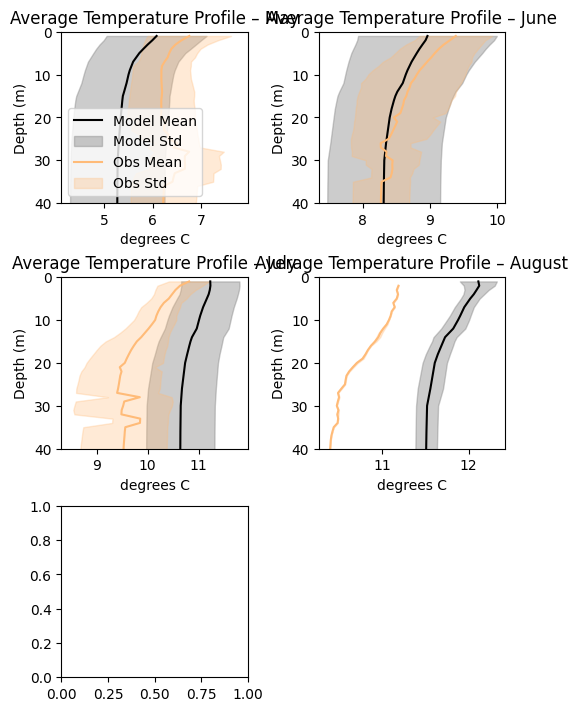

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIG ---
month_names = ["May", "June", "July", "August", "September"]
n_months = 4# May–Sep
palette = plt.get_cmap("tab20")

# --- TAKE MEAN OVER ALL 12 STATIONS ---
model_mean = t_values_combined.isel(type=0).mean(dim="location")
model_std  = t_values_combined.isel(type=1).mean(dim="location")

# --- OBSERVATIONS: MEAN + STD ACROSS STATIONS ---
obs_monthly_mean = []
obs_monthly_std = []

for m in range(n_months):
    month_str = f"2024-{m+4:02d}"   # 05–09
    obs_sel = obs["Temperature"].sel(
        time=slice('2024-0'+str(m+5)+'-01','2024-0'+str(m+5)+'-30')
    )

    # mean over stations, then mean over time
    obs_mean_m = obs_sel.mean(dim="time").mean(dim="HV")
    obs_std_m  = obs_sel.std(dim="time").mean(dim="HV")

    obs_monthly_mean.append(obs_mean_m)
    obs_monthly_std.append(obs_std_m)

# --- SET UP FIGURE ---
fig, axarr = plt.subplots(
    nrows=3, ncols=2, figsize=(5, 7), constrained_layout=True
)
ax = axarr.flatten()

for m in range(n_months):

    # MODEL DATA FOR MONTH m
    model_mean_m = model_mean.isel(month=m+1)
    model_std_m  = model_std.isel(month=m+1)

    # OBS DATA FOR MONTH m
    obs_mean_m = obs_monthly_mean[m]
    obs_std_m  = obs_monthly_std[m]

    # --- PLOTTING ---
    ax[m].plot(model_mean_m, s_values_combined.depth*(-1), color='black', label="Model Mean")
    ax[m].fill_betweenx(
        s_values_combined.depth*(-1),
        model_mean_m - model_std_m,
        model_mean_m + model_std_m,
        color="grey", alpha=0.4, label="Model Std"
    )

    ax[m].plot(obs_mean_m, obs.sel(HV=1).depth, color=palette(3), label="Obs Mean")
    ax[m].fill_betweenx(
        obs.sel(HV=1).depth,
        obs_mean_m - obs_std_m,
        obs_mean_m + obs_std_m,
        color=palette(3), alpha=0.3, label="Obs Std"
    )

    # TITLE + LABELS
    ax[m].set_title(f"Average Temperature Profile – {month_names[m]}")
    ax[m].set_xlabel("degrees C")
    ax[m].set_ylabel("Depth (m)")
    ax[m].set_ylim(0,40)
    # invert depth
    ax[m].invert_yaxis()

    # legend on first panel
    if m == 0:
        ax[m].legend()

# Remove empty subplot (6th)
fig.delaxes(ax[5])

plt.show()


In [60]:
import xarray as xr
import numpy as np

# Load ROMS output using your pattern
roms_output = ROMSOutput(
    grid=grid,
    path=[
        model_data_path,
    ],
    use_dask=True,
)

ds = roms_output.regrid(var_names=["temp", "salt"],depth_levels=[5])


In [61]:
t=ds['temp'].thin({'time': 24}).load()
s=ds['salt'].thin({'time': 24}).load()

In [62]:
# Define file paths and station names
stations = ["HVIN_1", "HVNA_1", "HVNV_1", "HVSA_1", "HVSV_1"]
file_paths = {name: f"/global/cfs/cdirs/m4632/uheede/Hafro_obsdata/{name}new.nc" for name in stations}
# Define file paths and station names
stations = ["HVIN_1", "HVNA_1", "HVNV_1", "HVSA_1", "HVSV_1"]
file_paths = {name: f"/home/x-uheede/R/HAFRO/{name}_TS.nc" for name in stations}

# Dictionary to store datasets
datasets = {}

for name, path in file_paths.items():
    ds = xr.open_dataset(path)
    
    # Store dataset with adjusted longitude
    datasets[name] = ds.assign_coords(lon=ds['lon'].load() + 360)

subtract = 739674 - 9189  # Computed constant
reference_date = pd.to_datetime("2000-01-01")  # Reference date

# Apply transformation to all datasets
for name, ds in datasets.items():
    datetime_series = reference_date + pd.to_timedelta((ds['time'].values - subtract), unit='D')
    datasets[name] = ds.assign_coords(time_dim=datetime_series)  # Update the time coordinate

ds_list = []

for name, ds in datasets.items():
    # Add station as a new dimension
    ds_expanded = ds.expand_dims(station=[name])
    ds_list.append(ds_expanded)
    
combined = xr.concat(ds_list, dim="station")
mean_ts = combined.mean(dim="station", skipna=True)

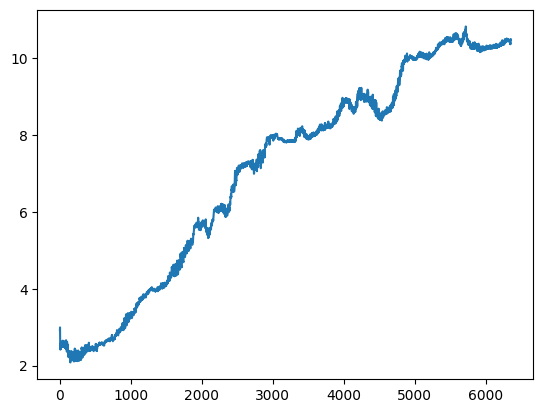

In [63]:
plt.plot(mean_ts['temperature'])

In [64]:
# Assuming locations is a list of lat/lon pairs
t_values = []
s_values = []
# Loop over the first 10 locations and store each selection in t_values
for i in range(12):
    lat, lon = locations[i]
    
    # Select the 't' values at the nearest lat/lon
    t_selected = t.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    s_selected = s.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
    
    # Store the result in the listx
    t_values.append(t_selected)
    s_values.append(s_selected)

# Combine the selections into an xarray Dataset or DataArray
t_values_combined = xr.concat(t_values, dim='location')
s_values_combined = xr.concat(s_values, dim='location')

# Assign a location coordinate for clarity (optional)
t_values_combined = t_values_combined.assign_coords(location=('location', range(1, 13)))
s_values_combined = s_values_combined.assign_coords(location=('location', range(1, 13)))
#t_values_combined['depth']=t_values_combined.depth*(-1)
#s_values_combined['depth']=s_values_combined.depth*(-1)
# Now you have t_values as an xarray object (Dataset or DataArray)
#print(t_values_combined)


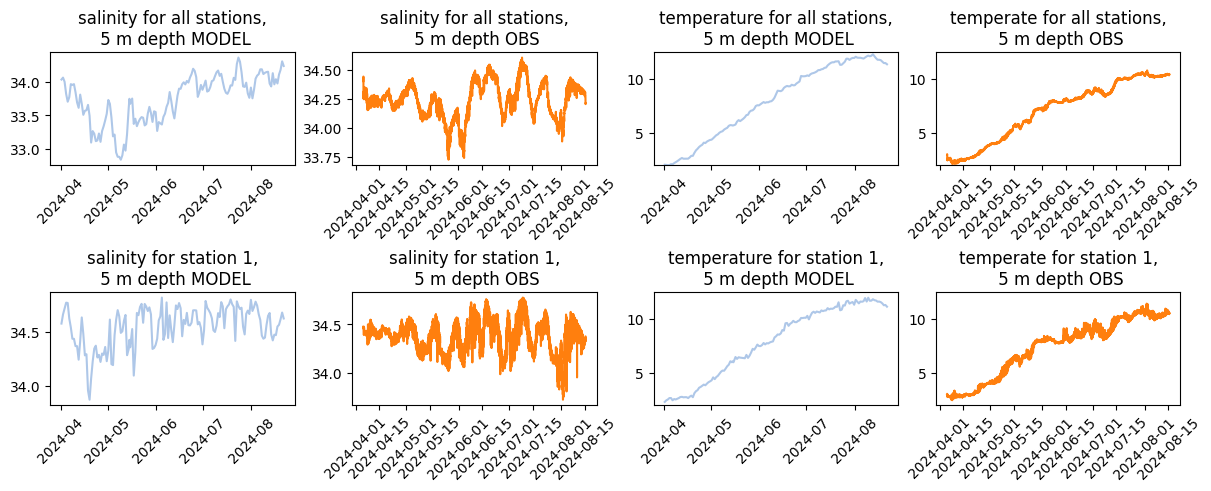

In [69]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(12, 4*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Plot observed salinity for May 2024
ax[1].plot(mean_ts['salinity'].time_dim.sel(time_dim=slice('04-01-2024', '09-01-2024')),
           mean_ts['salinity'].sel(time_dim=slice('04-01-2024', '09-01-2024')),
           label='May', color=palette(2))

ax[0].plot(s_values_combined.time, s_values_combined.sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[3].plot(mean_ts['temperature'].time_dim.sel(time_dim=slice('04-01-2024', '09-01-2024')),
           mean_ts['temperature'].sel(time_dim=slice('04-01-2024', '09-01-2024')),
           label='May', color=palette(2))
ax[3].set_ylim(2,12.5)

ax[2].plot(s_values_combined.time, t_values_combined.sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))
ax[2].set_ylim(2,12.5)
ax[5].plot(datasets['HVSV_1'].time_dim.sel(time_dim=slice('04-01-2024', '09-01-2024')),
           datasets['HVSV_1']['salinity'].sel(time_dim=slice('04-01-2024', '09-01-2024')),
           label='May', color=palette(2))

ax[4].plot(s_values_combined.time, s_values_combined.sel(location=[1]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[7].plot(datasets['HVSV_1'].time_dim.sel(time_dim=slice('04-01-2024', '09-01-2024')),
           datasets['HVSV_1']['temperature'].sel(time_dim=slice('04-01-2024', '09-01-2024')),
           label='May', color=palette(2))
ax[7].set_ylim(2,12.5)
ax[6].plot(s_values_combined.time, t_values_combined.sel(location=[1]).mean('location'),
           label='May', color=palette(1))
ax[6].set_ylim(2,12.5)
# Rotate x-axis labels for all subplots
for a in ax:
    a.tick_params(axis='x', rotation=45)  # Adjust rotation angle as needed
    
    
ax[0].set_title('salinity for all stations,\n 5 m depth MODEL')
ax[1].set_title('salinity for all stations,\n 5 m depth OBS')
ax[2].set_title('temperature for all stations,\n 5 m depth MODEL')
ax[3].set_title('temperate for all stations,\n 5 m depth OBS')
ax[4].set_title('salinity for station 1,\n 5 m depth MODEL')
ax[5].set_title('salinity for station 1,\n 5 m depth OBS')
ax[6].set_title('temperature for station 1,\n 5 m depth MODEL')
ax[7].set_title('temperate for station 1,\n 5 m depth OBS')
plt.show()



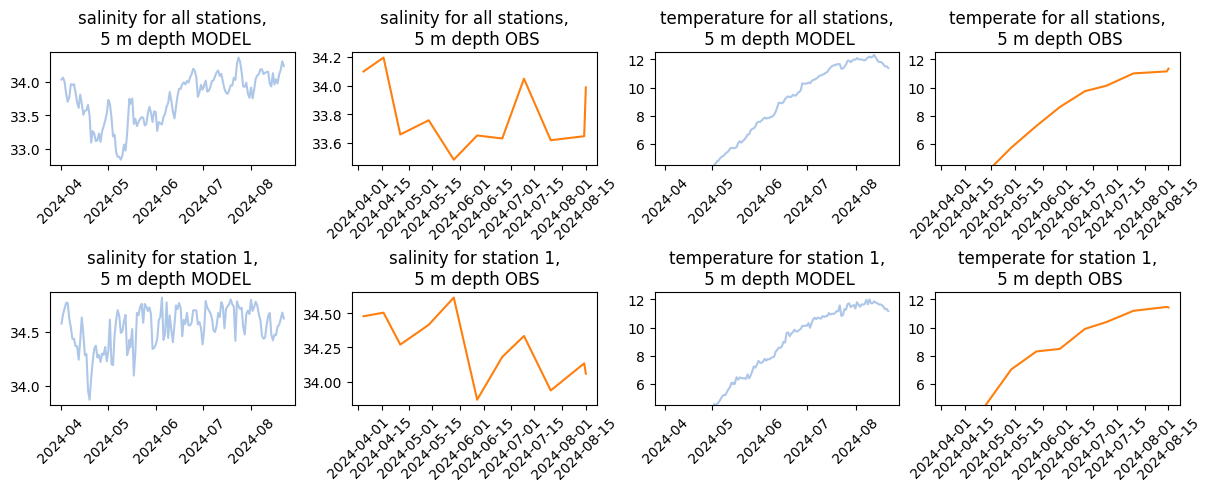

In [66]:
import matplotlib.pyplot as plt

# Set up the subplots
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(12, 4*1.2), constrained_layout=True)
ax = axarr.flatten()  # Flatten to make indexing easier
palette = plt.get_cmap('tab20')

# Plot observed salinity for May 2024
ax[1].plot(obs.time.sel(time=slice('04-01-2024', '09-01-2024')),
           obs['Salinity'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1,3,4,5,6,7,8,9,10,12]).sel(time=slice('04-01-2024', '09-01-2024')).mean('HV'),
           label='May', color=palette(2))

ax[0].plot(s_values_combined.time, s_values_combined.sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[3].plot(obs.time.sel(time=slice('04-01-2024', '09-01-2024')),
           obs['Temperature'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1,3,4,5,6,7,8,9,10,12]).sel(time=slice('04-01-2024', '09-01-2024')).mean('HV'),
           label='May', color=palette(2))
ax[3].set_ylim(4.5,12.5)

ax[2].plot(s_values_combined.time, t_values_combined.sel(location=[1,3,4,5,6,7,8,9,10,12]).mean('location'),
           label='May', color=palette(1))
ax[2].set_ylim(4.5,12.5)
ax[5].plot(obs.time.sel(time=slice('04-01-2024', '09-01-2024')),
           obs['Salinity'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1]).sel(time=slice('04-01-2024', '09-01-2024')).mean('HV'),
           label='May', color=palette(2))

ax[4].plot(s_values_combined.time, s_values_combined.sel(location=[1]).mean('location'),
           label='May', color=palette(1))

# Plot observed salinity for May 2024
ax[7].plot(obs.time.sel(time=slice('04-01-2024', '09-01-2024')),
           obs['Temperature'].sel(depth=slice(2,5)).mean('depth').sel(HV=[1]).sel(time=slice('04-01-2024', '09-01-2024')).mean('HV'),
           label='May', color=palette(2))
ax[7].set_ylim(4.5,12.5)
ax[6].plot(s_values_combined.time, t_values_combined.sel(location=[1]).mean('location'),
           label='May', color=palette(1))
ax[6].set_ylim(4.5,12.5)
# Rotate x-axis labels for all subplots
for a in ax:
    a.tick_params(axis='x', rotation=45)  # Adjust rotation angle as needed
    
    
ax[0].set_title('salinity for all stations,\n 5 m depth MODEL')
ax[1].set_title('salinity for all stations,\n 5 m depth OBS')
ax[2].set_title('temperature for all stations,\n 5 m depth MODEL')
ax[3].set_title('temperate for all stations,\n 5 m depth OBS')
ax[4].set_title('salinity for station 1,\n 5 m depth MODEL')
ax[5].set_title('salinity for station 1,\n 5 m depth OBS')
ax[6].set_title('temperature for station 1,\n 5 m depth MODEL')
ax[7].set_title('temperate for station 1,\n 5 m depth OBS')
plt.show()



In [67]:
s_values_combined

<xarray.DataArray 'salt' (location: 12, time: 144, depth: 1)> Size: 14kB
array([[[34.57928269],
        [34.66392677],
        [34.71920039],
        ...,
        [34.6196415 ],
        [34.68104413],
        [34.62649604]],

       [[34.20010971],
        [34.29992175],
        [34.56100149],
        ...,
        [34.59542182],
        [34.55340279],
        [34.59314847]],

       [[34.4841973 ],
        [34.66466217],
        [34.41018199],
        ...,
...
        ...,
        [33.69644646],
        [34.41936063],
        [34.3297629 ]],

       [[33.91874539],
        [33.7434176 ],
        [33.64993956],
        ...,
        [34.01743941],
        [34.2246865 ],
        [34.12559398]],

       [[32.95074822],
        [33.7193593 ],
        [33.96114602],
        ...,
        [33.76883865],
        [34.03096983],
        [33.45588682]]], shape=(12, 144, 1))
Coordinates:
  * time      (time) datetime64[ns] 1kB 2024-04-01T12:00:00 ... 2024-08-21T19...
    lat       (location) float32 48B 64.27 64.29 64.3 ... 64.38 64.39 64.36
    lon       (location) float32 48B 338.0 338.1 338.1 ... 338.5 338.5 338.6
  * depth     (depth) float32 4B 5.0
  * location  (location) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  salinity
    units:      PSU